### import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib3

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset

In [3]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True)
num_classes = ds_info.features["label"].num_classes

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


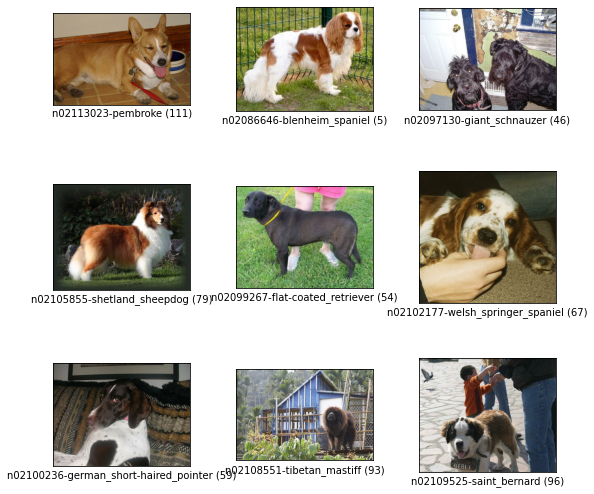

In [4]:
fig = tfds.show_examples(ds_info, ds_train)

## 1. Augmentation을 적용한 데이터셋 만들기

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False ,with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size) 
    if not is_test and with_cutmix: # cutmix
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup: # mixup
        ds = ds.map(mixup, num_parallel_calls=2)    
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


### CutMix 함수


In [6]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [7]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [9]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### MixUp

In [10]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [11]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


### Model

In [13]:
tf.random.set_seed(2020)

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [14]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### No Augmentation

In [15]:
history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 203ms/step - loss: 2.2156 - accuracy: 0.4491 - val_loss: 3.5178 - val_accuracy: 0.1875
Epoch 2/20
750/750 [==============================] - 151s 201ms/step - loss: 0.7273 - accuracy: 0.7966 - val_loss: 1.3176 - val_accuracy: 0.6210
Epoch 3/20
750/750 [==============================] - 151s 201ms/step - loss: 0.2518 - accuracy: 0.9448 - val_loss: 0.9958 - val_accuracy: 0.7087
Epoch 4/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0677 - accuracy: 0.9935 - val_loss: 0.8847 - val_accuracy: 0.7423
Epoch 5/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0286 - accuracy: 0.9989 - val_loss: 0.8939 - val_accuracy: 0.7443
Epoch 6/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0188 - accuracy: 0.9996 - val_loss: 0.9313 - val_accuracy: 0.7394
Epoch 7/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0126 - accuracy: 0.9998 - val_loss: 0.9185 -

### 기본augmetaion 적용

In [16]:
basic_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [17]:
basic_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [18]:
history_basic_aug_resnet50 = basic_aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 158s 202ms/step - loss: 2.2625 - accuracy: 0.4301 - val_loss: 2.9426 - val_accuracy: 0.2715
Epoch 2/20
750/750 [==============================] - 151s 201ms/step - loss: 0.9392 - accuracy: 0.7322 - val_loss: 1.2303 - val_accuracy: 0.6416
Epoch 3/20
750/750 [==============================] - 151s 201ms/step - loss: 0.4898 - accuracy: 0.8673 - val_loss: 1.3886 - val_accuracy: 0.6121
Epoch 4/20
750/750 [==============================] - 151s 201ms/step - loss: 0.2680 - accuracy: 0.9346 - val_loss: 1.1040 - val_accuracy: 0.6971
Epoch 5/20
750/750 [==============================] - 166s 222ms/step - loss: 0.1438 - accuracy: 0.9738 - val_loss: 1.1845 - val_accuracy: 0.6749
Epoch 6/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0781 - accuracy: 0.9892 - val_loss: 1.0221 - val_accuracy: 0.7196
Epoch 7/20
750/750 [==============================] - 150s 201ms/step - loss: 0.0531 - accuracy: 0.9929 - val_loss: 1.0524 -

### CutMix 적용

In [19]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [20]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [21]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 159s 203ms/step - loss: 3.8262 - accuracy: 0.2115 - val_loss: 3.5907 - val_accuracy: 0.1839
Epoch 2/20
750/750 [==============================] - 152s 202ms/step - loss: 2.9169 - accuracy: 0.4387 - val_loss: 1.3230 - val_accuracy: 0.6221
Epoch 3/20
750/750 [==============================] - 151s 202ms/step - loss: 2.6322 - accuracy: 0.5310 - val_loss: 1.1571 - val_accuracy: 0.6673
Epoch 4/20
750/750 [==============================] - 151s 202ms/step - loss: 2.4202 - accuracy: 0.5908 - val_loss: 1.2037 - val_accuracy: 0.6616
Epoch 5/20
750/750 [==============================] - 152s 202ms/step - loss: 2.2387 - accuracy: 0.6491 - val_loss: 1.2749 - val_accuracy: 0.6490
Epoch 6/20
750/750 [==============================] - 167s 223ms/step - loss: 2.1245 - accuracy: 0.6906 - val_loss: 1.2864 - val_accuracy: 0.6523
Epoch 7/20
750/750 [==============================] - 152s 202ms/step - loss: 2.0137 - accuracy: 0.7281 - val_loss: 1.4385 -

### MixUp 적용

In [22]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [23]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [24]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 159s 203ms/step - loss: 3.7583 - accuracy: 0.2363 - val_loss: 3.9688 - val_accuracy: 0.1174
Epoch 2/20
750/750 [==============================] - 152s 202ms/step - loss: 2.8857 - accuracy: 0.4753 - val_loss: 1.4152 - val_accuracy: 0.6114
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 2.5968 - accuracy: 0.5767 - val_loss: 1.4660 - val_accuracy: 0.5910
Epoch 4/20
750/750 [==============================] - 152s 202ms/step - loss: 2.3965 - accuracy: 0.6566 - val_loss: 1.3019 - val_accuracy: 0.6386
Epoch 5/20
750/750 [==============================] - 152s 202ms/step - loss: 2.2380 - accuracy: 0.7140 - val_loss: 1.2141 - val_accuracy: 0.6630
Epoch 6/20
750/750 [==============================] - 152s 202ms/step - loss: 2.1774 - accuracy: 0.7412 - val_loss: 1.3306 - val_accuracy: 0.6369
Epoch 7/20
750/750 [==============================] - 152s 202ms/step - loss: 2.0749 - accuracy: 0.7701 - val_loss: 1.3159 -

## 시각화 하기 

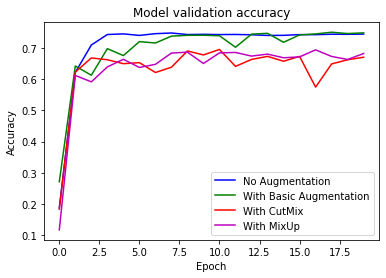

In [25]:
plt.plot(history_resnet50.history['val_accuracy'], 'b')
plt.plot(history_basic_aug_resnet50.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.show()

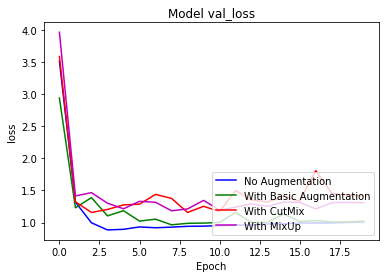

In [30]:
plt.plot(history_resnet50.history['val_loss'], 'b')
plt.plot(history_basic_aug_resnet50.history['val_loss'], 'g')
plt.plot(history_cutmix_resnet50.history['val_loss'], 'r')
plt.plot(history_mixup_resnet50.history['val_loss'], 'm')

plt.title('Model val_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.show()

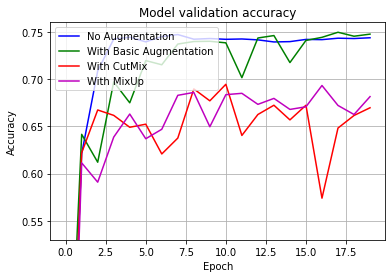

In [27]:
plt.plot(history_resnet50.history['val_accuracy'], 'b')
plt.plot(history_basic_aug_resnet50.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')


plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.53, 0.76)
plt.show()

### 결론 

cut mix와 Mix up 을 적용했더니 오히려 정확도가 떨어졌다. loss 값도 augmentation을 적용하지 않은 것이 제일 낮앗고  cutmix와 Mixup을 적용한 결과는 그리 좋게 나오지 않았다. 이런 결과가 나오게 된 이유는 아마도 샘플 파일을 보면 개 사진에 여러 배경및 사람도 많이 섞여 있고 개 혼자만 있는 사진은 거의 없었다. 이에 따라서 cutmix나 Mixup을 적용했던게 손상된 데이터를 추가해서 모델이 학습하는데 방해가 되었다고 추측한다.